In [1]:
from __future__ import print_function, division

import matplotlib
import imageio
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Creating Folders before Downloading Data

In [2]:
folderlocation = './Data/'
path = folderlocation
if not os.path.exists(path):
    os.mkdir(path)

path = folderlocation + 'train/'
if not os.path.exists(path):
    os.mkdir(path)
        
path = folderlocation + 'valid/'
if not os.path.exists(path):
    os.mkdir(path)

path = folderlocation + 'test/'
if not os.path.exists(path):
    os.mkdir(path)
    
for iter1 in range(10):    # 10 = number of classes
    path = folderlocation + 'train/'+str(iter1)
    if not os.path.exists(path):
        os.mkdir(path)
    path = folderlocation + 'valid/'+str(iter1)
    if not os.path.exists(path):
        os.mkdir(path)
    
    path = folderlocation + 'test/'+str(iter1)
    if not os.path.exists(path):
        os.mkdir(path)

# Download Data and Arrange in Folders

In [3]:
data_train = torchvision.datasets.FashionMNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                             ]))
        
for iter1 in range(len(data_train)):
    x, a = data_train[iter1] 
    if iter1%10 ==0:
        imageio.imwrite(folderlocation + 'valid/'+str(a)+'/valid'+str(iter1)+'.png', x)
    else:
        imageio.imwrite(folderlocation + 'train/'+str(a)+'/train'+str(iter1)+'.png', x)
    
data_test = torchvision.datasets.FashionMNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                             ]))

for iter1 in range(len(data_test)):
    x, a = data_test[iter1] 
    imageio.imwrite(folderlocation + 'test/'+str(a)+'/test'+str(iter1)+'.png', x)

0it [00:00, ?it/s]

Extracting /files/FashionMNIST/raw/train-images-idx3-ubyte.gz to /files/FashionMNIST/raw


0it [00:00, ?it/s]

Extracting /files/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /files/FashionMNIST/raw


0it [00:00, ?it/s]

Extracting /files/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /files/FashionMNIST/raw


0it [00:00, ?it/s]

Extracting /files/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /files/FashionMNIST/raw
Processing...
Done!


/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729047590/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Define Data Transforms and Visualization

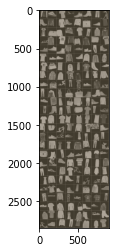

In [4]:
plt.ion()   # interactive mode

# Data augmentation and normalization for training
# Just normalization for validation


data_transforms = {
    'train': transforms.Compose([
                                transforms.Resize(120),                                       
                                transforms.RandomHorizontalFlip(0.5),
                                transforms.RandomAffine(degrees=10, translate=(0.2, 0.2)), 
                                transforms.RandomResizedCrop(112, scale=(0.95,1)),
                                transforms.ToTensor(),
                                transforms.Normalize(
                                 (0.5,), (0.5,))
                             ]),
    'valid': transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Resize(112),
                               transforms.Normalize(
                                 (0.5,), (0.5,))
                             ]),
    'test': transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Resize(112),
                               transforms.Normalize(
                                 (0.5,), (0.5,))
                             ]),
}


data_dir = folderlocation
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'valid', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=200,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'valid', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid', 'test']}
class_names = image_datasets['train'].classes


def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out)#, title=[class_names[x] for x in classes])

# Model Download and Change FC/Classifier Layer

In [5]:
#model_ft = models.vgg19_bn(pretrained=True)
#num_ftrs = model_ft.classifier[0].in_features

model_ft = models.wide_resnet101_2(pretrained=True)
num_ftrs = model_ft.fc.in_features

half_in_size = round(num_ftrs/2)
layer_width = 1024
Num_class=10

class SpinalNet(nn.Module):
    def __init__(self):
        super(SpinalNet, self).__init__()
        
        self.fc_spinal_layer1 = nn.Sequential(
            nn.Dropout(p = 0.5), nn.Linear(half_in_size, layer_width),
            nn.BatchNorm1d(layer_width), nn.ReLU(inplace=True),)
        self.fc_spinal_layer2 = nn.Sequential(
            nn.Dropout(p = 0.5), nn.Linear(half_in_size+layer_width, layer_width),
            nn.BatchNorm1d(layer_width), nn.ReLU(inplace=True),)
        self.fc_spinal_layer3 = nn.Sequential(
            nn.Dropout(p = 0.5), nn.Linear(half_in_size+layer_width, layer_width),
            nn.BatchNorm1d(layer_width), nn.ReLU(inplace=True),)
        self.fc_spinal_layer4 = nn.Sequential(
            nn.Dropout(p = 0.5), nn.Linear(half_in_size+layer_width, layer_width),
            nn.BatchNorm1d(layer_width), nn.ReLU(inplace=True),)
        self.fc_out = nn.Sequential(
            nn.Dropout(p = 0.5), nn.Linear(layer_width*4, Num_class),)
        
        

    def forward(self, x):
        x1 = self.fc_spinal_layer1(x[:, 0:half_in_size])
        x2 = self.fc_spinal_layer2(torch.cat([ x[:,half_in_size:2*half_in_size], x1], dim=1))
        x3 = self.fc_spinal_layer3(torch.cat([ x[:,0:half_in_size], x2], dim=1))
        x4 = self.fc_spinal_layer4(torch.cat([ x[:,half_in_size:2*half_in_size], x3], dim=1))
        
        
        x = torch.cat([x1, x2], dim=1)
        x = torch.cat([x, x3], dim=1)
        x = torch.cat([x, x4], dim=1)

        
        x = self.fc_out(x)
        return x

class SpinalNet_Resnet(nn.Module):
    def __init__(self):
        super(SpinalNet_Resnet, self).__init__()
        
        self.layer1 = nn.Linear(half_in_size, layer_width)
        self.layer2 = nn.Linear(half_in_size+layer_width, layer_width)
        self.layer3 = nn.Linear(half_in_size+layer_width, layer_width)
        self.layer4 = nn.Linear(half_in_size+layer_width, layer_width)
        self._out = nn.Linear(layer_width*4, Num_class)
        
    def forward(self, x):
        x1 = self.layer1(x[:, 0:half_in_size])
        x2 = self.layer2(torch.cat([ x[:,half_in_size:2*half_in_size], x1], dim=1))
        x3 = self.layer3(torch.cat([ x[:,0:half_in_size], x2], dim=1))
        x4 = self.layer4(torch.cat([ x[:,half_in_size:2*half_in_size], x3], dim=1))
        
        x = torch.cat([x1, x2], dim=1)
        x = torch.cat([x, x3], dim=1)
        x = torch.cat([x, x4], dim=1)

        x = self._out(x)
        return x

net_fc = nn.Sequential(
            nn.Linear(512, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, Num_class)
        )


def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    test_token=0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid', 'test']:
             
            
            '''
            Test when a better validation result is found
            '''
            if test_token ==0 and phase == 'test':
                continue
            test_token =0
            
            
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                test_token =1


        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model
'''
Changing the fully connected layer to SpinalNet
'''

model_ft.fc = SpinalNet_Resnet()#nn.Linear(num_ftrs, 10)
#model_ft.classifier = SpinalNet()



model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

Downloading: "https://download.pytorch.org/models/wide_resnet101_2-32ee1156.pth" to /root/.cache/torch/hub/checkpoints/wide_resnet101_2-32ee1156.pth


  0%|          | 0.00/243M [00:00<?, ?B/s]

# Training (lr=0.01)

In [6]:
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=5)

Epoch 0/4
----------
train Loss: 0.4102 Acc: 0.8573
valid Loss: 0.2259 Acc: 0.9157
test Loss: 0.2352 Acc: 0.9136

Epoch 1/4
----------
train Loss: 0.2117 Acc: 0.9226
valid Loss: 0.1936 Acc: 0.9288
test Loss: 0.2044 Acc: 0.9276

Epoch 2/4
----------
train Loss: 0.1782 Acc: 0.9349
valid Loss: 0.1848 Acc: 0.9362
test Loss: 0.1968 Acc: 0.9317

Epoch 3/4
----------
train Loss: 0.1574 Acc: 0.9422
valid Loss: 0.1748 Acc: 0.9387
test Loss: 0.1860 Acc: 0.9349

Epoch 4/4
----------
train Loss: 0.1447 Acc: 0.9473
valid Loss: 0.1704 Acc: 0.9417
test Loss: 0.1808 Acc: 0.9368

Training complete in 41m 55s
Best val Acc: 0.941667


# Training (lr=0.001)

In [7]:
# lr=0.001
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=5)

Epoch 0/4
----------
train Loss: 0.1065 Acc: 0.9614
valid Loss: 0.1515 Acc: 0.9488
test Loss: 0.1616 Acc: 0.9447

Epoch 1/4
----------
train Loss: 0.0943 Acc: 0.9659
valid Loss: 0.1491 Acc: 0.9503
test Loss: 0.1601 Acc: 0.9462

Epoch 2/4
----------
train Loss: 0.0882 Acc: 0.9677
valid Loss: 0.1462 Acc: 0.9522
test Loss: 0.1554 Acc: 0.9475

Epoch 3/4
----------
train Loss: 0.0812 Acc: 0.9705
valid Loss: 0.1484 Acc: 0.9522

Epoch 4/4
----------
train Loss: 0.0777 Acc: 0.9721
valid Loss: 0.1490 Acc: 0.9525
test Loss: 0.1575 Acc: 0.9476

Training complete in 41m 26s
Best val Acc: 0.952500


# Save Model

In [8]:
#Save model

# Specify a path
PATH = "state_dict_model.pt"

# Save
torch.save(model_ft.state_dict(), PATH)

## Load
#model = Net()
#model.load_state_dict(torch.load(PATH))
#model.eval()

# Build Confusion Matrix

In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        output = model_ft(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes],
                     columns = [i for i in classes])


# Plot Confusion Matrix

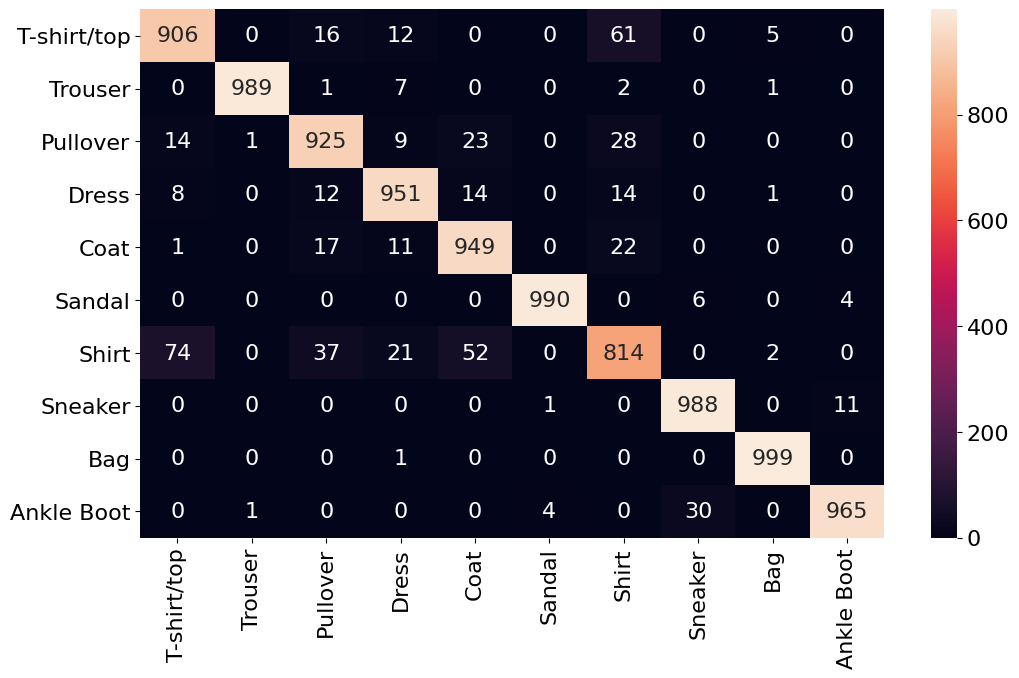

In [10]:
plt.figure(figsize = (12,7),dpi=100)
plt.rcParams['font.size'] = '16'
sn.heatmap(df_cm, annot=True, fmt=".0f")
plt.savefig('output.png')

# Delete Downloaded Data

In [11]:
import shutil
shutil.rmtree(folderlocation)